# Page Rank

### ¿Qué es el PageRank?

Es un algoritmo utilizado por Google Search para ranker páginas web y así poderlas desplegar en sus resultados de motor de búsqueda. 

PageRank es una forma de medir la importancia de las páginas web. Y funciona a partir del número y la calidad de los `outlinks` que tiene una página web. La suposición que se realiza en este algoritmo es que las páginas web más importantes son más comunes de ser linkeadas de otras páginas web.

No es el único algoritmo utilizado para el motor de búsqueda de Google, pero fue el primero y el más conocido.

### Algoritmo

El resultado del algoritmo es una distribución de la probabilidad que representa la probabilidad que una persona dando click random a los links puede llegar a esa página en particulas. 

Al principio el pagerank mantiene una probabilidad igual en todos los documentos de la colección del proceso computacional. Después, el proceso requiere multiples pasos, a los que se les llamará, iteraciones, para ajustar el valor del pagerank aproximado para reflejar el valor real teórico.

### Fórmula iterativa:

$$
PR_{t+1}(P_j) = \sum_{P_j}\frac{PR_t(P_j)}{C(P_j)}
$$

donde en la iteración 0 , se inicializa un vector de tamaño n, y sus valores inciales para cada posición será $\frac{1}{n}$

### Representación en matriz:

Se pueden utilizar operaciones matriciales en vez de realizar la forma iterativa (donde se hacen cálculos y actualizaciones de valores de uno por uno).

Con las operaciones matriciales se pueden realizar múltiples cálculos al mismo tiempo.

Debemos definir nuestra matriz que debe ser **estocástica** que nos ayuda a describir las transiciones en una cadena de Markov.

Esta matriz se definirá por los outlinks y el número de éstos por cada página. **(Ver sección de Ejemplo)**

El método utilizado para realizar estos cálculos de forma más sencilla es el **método de la potencia**

##### Método de la potencia

$$ PR_{t+1} = H PR_t$$

donde H es la matriz estocástica

Esta matriz se debe multiplicar con un vector en cada iteración, ¿pero cuál es el vector inicial?

Como se ha mencionado previamente, el vector inicial será un vector de tamaño n, y sus valores inciales para cada posición será $\frac{1}{n}$

Entonces para obtener el vector de la siguiente iteración esta dado por:
    $$v_2 = H v$$

Siguiente iteración:

$$v_3 = H v_2 = H (H v) = H^2 v$$

Entonces:
    
$$v_n = H^{(n-1)} v$$

Si hacemos varias iteraciones, converge a un valor de equilibrio.

### Ejemplo:

Supongamos que tenemos 4 páginas web donde:
- la página A apunta a las páginas C y B
- la página B apunta a la página D
- la pagina C apunta a las páiginas A, B, D
- la página D apunta a la página C

Veámoslo de forma gráfica

In [5]:
import numpy as np
import math
import pandas as pd
from scipy.sparse import csr_matrix 
  
# Para las pruebas
from pytest import approx
import pprint
# Para los grafos
import networkx as nx
import matplotlib.pyplot as plt

In [7]:
pages_links = pd.DataFrame( columns=['pagina', 'outlinks'])
pages_links['pagina'] = ['A', 'B', 'C', 'D']
pages_links['outlinks'][0] = ['C', 'B']
pages_links['outlinks'][1] = ['D']
pages_links['outlinks'][2] = ['A', 'B', 'D']
pages_links['outlinks'][3] = ['C']

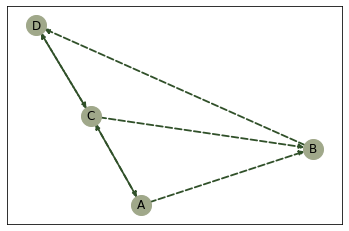

In [8]:
nodos = pages_links['pagina']

G = nx.DiGraph()

for nodo in nodos:
    G.add_node(nodo)
    
for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    for outlink in outlinks:
        G.add_edge(page, outlink)

pos = nx.spring_layout(G)


nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
nx.draw_networkx_labels(G, pos)
nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

plt.show()

Definimos nuestra matriz estocástica conforme a lo previamente definido

In [9]:
sparseMatrix = csr_matrix((len(pages_links), len(pages_links)),  
                          dtype = np.float).toarray() 
newdf = pd.DataFrame(sparseMatrix, columns = pages_links['pagina'], index=pages_links['pagina'])
count = 0
for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    score = 1/len(outlinks)
    dict_page = {page: np.zeros(len(pages_links))}
    for outlink in outlinks:
        newdf[page][outlink] = score

In [11]:
H = newdf.to_numpy()
H

array([[0.        , 0.        , 0.33333333, 0.        ],
       [0.5       , 0.        , 0.33333333, 0.        ],
       [0.5       , 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.33333333, 0.        ]])

Definimos el vector inicial

Que en este caso será:

\begin{align}
    v &= \begin{bmatrix}
           1/4 \\
           1/4 \\
           1/4 \\
           1/4
         \end{bmatrix}
  \end{align}

In [12]:
v = np.ones(len(pages_links))
v = v*1/len(v)
pprint.pprint(v)

array([0.25, 0.25, 0.25, 0.25])


Como habíamos definido antes: 

$$v_n = H^{n-1}v$$

donde n será el número de iteraciones. 

En este caso probaremos con 20 iteraciones para obtener el vector 21.

In [13]:
n = 20
H = np.linalg.matrix_power(H, n)
v_n = H@v

Cuando hacemos los cálculos obtenemos $v_n$

In [14]:
v_n

array([0.12500368, 0.18750089, 0.37499297, 0.31250246])

Para mejor entendimiento:

In [17]:
df = pd.DataFrame(v_n, columns=['pagerank'])

df['nodo'] = pages_links['pagina']
df = df.set_index('nodo')

df

,pagerank
nodo,
A,0.125004
B,0.187501
C,0.374993
D,0.312502


Volvemos a graficar con sus respectivos pagerank y podemos observar que C es la página con más alto pagerank, por lo tanto será mostrado primero en el motor de búsqueda.

In [18]:
power_method = df.pagerank.to_dict()

power_method_round = {}    
for node in power_method:
    if node in power_method:
        #set the node name as the key and the label as its value 
        power_method_round[node] = round(power_method[node],2)

{'A': 'A:0.13', 'B': 'B:0.19', 'C': 'C:0.37', 'D': 'D:0.31'}


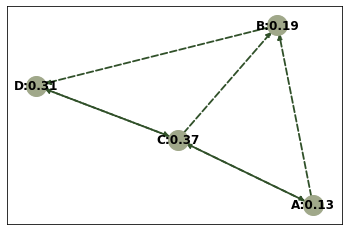

In [19]:
G = nx.DiGraph()

for nodo in power_method:
    G.add_node(nodo)

for page, outlinks in zip(pages_links['pagina'],pages_links['outlinks']):
    for outlink in outlinks:
        G.add_edge(page, outlink)

pos = nx.spring_layout(G)

labels = {}    
for node in G.nodes():
    if node in power_method:
        #set the node name as the key and the label as its value 
        labels[node] = "{}:{}".format(node,round(power_method[node],2))

# Es lo mismo que power_method pero redondeado        
print(labels)

nx.draw_networkx_nodes(G, pos, node_color='#a0a88a', node_size=400)
nx.draw_networkx_labels(G, pos, labels=labels, font_weight="bold")
nx.draw_networkx_edges(G, pos, edge_color='#305029', width=1.8, arrows = True, style='dashed')

plt.show()

## Referencias:

- [PageRank](https://www.geeksforgeeks.org/page-rank-algorithm-implementation/)
- [Método de la potencia](https://video.search.yahoo.com/yhs/search?fr=yhs-ddc-linuxmint&hsimp=yhs-linuxmint&hspart=ddc&p=page+rank#id=9&vid=b35a1c4b4379bde2aeb371cd71f68b6b&action=view)
- [Ejemplo](https://github.com/lecepe00/PageRank-eigenvectores-eigenvalores/tree/main/Implementacion)